# March Madness Prediction

## Overview

### Goal
Submissions are based on the Brier Score, the goal will be to minimize the brier score between the predicted probabilities and the actual game outcomes. The Brier score measures the accuracy of probablistic predition, in this case the mean square error. 

The brier score can be thought of as a cost function that measures the average squared difference between the predicted probabilities and the actual outcomes.

$$
Brier = \frac{1}{N} \sum_{i=1}^{N} (p_i - o_i)^2
$$

where $p_i$ is the predicted probability of the event and $o_i$ is the actual outcome. The Brier score can span across all items in a set of N predictions.

Therefore, minimizing the Brier score will result in a more accurate prediction.


## Import Libraries
Numpy for numerical operations
Pandas for data manipulation
Matplotlib, Seaborn, Plotly for plotting


In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import xgboost as xgb
import sklearn as sk

## Load Data

Set up a data dictionary that will store the data for each file, this will make it easier to access data from the csvs. Not all files are used in the prediction process, but they are included for completeness.


In [3]:
data_dir = 'data/'
data = {}

files = glob.glob(data_dir + '*.csv')
for file in files:
    filename = file.split('/')[-1].split('\\')[-1].split('.')[0]
    try:
        data[filename] = pd.read_csv(file, encoding='latin-1')
    except Exception as e:
        print(f"Warning: Could not load {filename}: {e}")



Now that we have the data loaded, lets start by loading team and team spelling data. Here we will be using the team and team spelling data from the regular season and tournament. Combining women and mens data to get a complete dataset.


In [4]:
teams = pd.concat([data['MTeams'], data['WTeams']])
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
print(teams.head())

   TeamID     TeamName  FirstD1Season  LastD1Season  TeamNameCount
0    1101  Abilene Chr         2014.0        2025.0              3
1    1102    Air Force         1985.0        2025.0              2
2    1103        Akron         1985.0        2025.0              1
3    1104      Alabama         1985.0        2025.0              1
4    1105  Alabama A&M         2000.0        2025.0              2


Add season and turney reluts, both compact and detailed. There is a chance we only end up using the detailed results, but it is good to have both. 

In [5]:
season_compact_results = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']]).assign(ST='S')
season_detailed_results = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']]).assign(ST='S')
tourney_compact_results = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']]).assign(ST='T')
tourney_detailed_results = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']]).assign(ST='T')

We will create a summary of the datasets. This will help us understand the shape of the data and the columns that are available. Which will be important when we start to explore the data and feature engineering.

In [7]:
# Create a summary of the datasets
summary = pd.DataFrame({
    'Dataset': [
        'Regular Season Compact',
        'Regular Season Detailed',
        'Tournament Compact',
        'Tournament Detailed'
    ],
    'Shape': [
        season_compact_results.shape,
        season_detailed_results.shape,
        tourney_compact_results.shape,
        tourney_detailed_results.shape
    ],
    'Columns': [
        len(season_compact_results.columns),
        len(season_detailed_results.columns),
        len(tourney_compact_results.columns),
        len(tourney_detailed_results.columns)
    ],
    'Sample Years': [
        f"{season_compact_results['Season'].min()}-{season_compact_results['Season'].max()}",
        f"{season_detailed_results['Season'].min()}-{season_detailed_results['Season'].max()}",
        f"{tourney_compact_results['Season'].min()}-{tourney_compact_results['Season'].max()}",
        f"{tourney_detailed_results['Season'].min()}-{tourney_detailed_results['Season'].max()}"
    ]
})

# Display the summary with nice formatting
display(summary.style.set_properties(**{
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'text-align': 'center'
}))

# If you want to see the first few rows of each dataset, you can also do:
# print("\nSample of Regular Season Compact Results:")
# display(season_compact_results.head(3))

# print("\nSample of Regular Season Detailed Results:")
# display(season_detailed_results.head(3))

# print("\nSample of Tournament Compact Results:")
# display(tourney_compact_results.head(3))

# print("\nSample of Tournament Detailed Results:")
# display(tourney_detailed_results.head(3))

,Dataset,Shape,Columns,Sample Years
0,Regular Season Compact,"(329125, 9)",9,1985-2025
1,Regular Season Detailed,"(199757, 35)",35,2003-2025
2,Tournament Compact,"(4168, 9)",9,1985-2024
3,Tournament Detailed,"(2276, 35)",35,2003-2024


In [9]:
# Load other data that might prove useful
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
seeds['SeedValue'] = seeds['Seed'].str.extract(r'(\d+)').astype(int)
seeds_dict = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}
game_cities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

# Combine all game results
all_compact_results = pd.concat([season_compact_results, tourney_compact_results])
all_detailed_results = pd.concat([season_detailed_results, tourney_detailed_results])


## Feature Engineering



In [12]:
# Add derived features to compact results
all_compact_results['ScoreDiff'] = all_compact_results['WScore'] - all_compact_results['LScore']
all_compact_results['HomeAdvantage'] = all_compact_results['WLoc'].map({'H': 1, 'N': 0, 'A': -1})

# Add derived features to detaifled results
all_detailed_results['ScoreDiff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
all_detailed_results['HomeAdvantage'] = all_detailed_results['WLoc'].map({'H': 1, 'N': 0, 'A': -1})

    # Calculate shooting percentages (handling division by zero)
all_detailed_results['WFGPct'] = np.where(all_detailed_results['WFGA'] > 0, 
                                        all_detailed_results['WFGM'] / all_detailed_results['WFGA'], 0)
all_detailed_results['WFG3Pct'] = np.where(all_detailed_results['WFGA3'] > 0, 
                                        all_detailed_results['WFGM3'] / all_detailed_results['WFGA3'], 0)
all_detailed_results['WFTPct'] = np.where(all_detailed_results['WFTA'] > 0, 
                                        all_detailed_results['WFTM'] / all_detailed_results['WFTA'], 0)
all_detailed_results['LFGPct'] = np.where(all_detailed_results['LFGA'] > 0, 
                                        all_detailed_results['LFGM'] / all_detailed_results['LFGA'], 0)
all_detailed_results['LFG3Pct'] = np.where(all_detailed_results['LFGA3'] > 0, 
                                        all_detailed_results['LFGM3'] / all_detailed_results['LFGA3'], 0)
all_detailed_results['LFTPct'] = np.where(all_detailed_results['LFTA'] > 0, 
                                        all_detailed_results['LFTM'] / all_detailed_results['LFTA'], 0)

# Add statistical differences
all_detailed_results['ReboundDiff'] = (all_detailed_results['WOR'] + all_detailed_results['WDR']) - \
                                    (all_detailed_results['LOR'] + all_detailed_results['LDR'])
all_detailed_results['AssistDiff'] = all_detailed_results['WAst'] - all_detailed_results['LAst']
all_detailed_results['TurnoverDiff'] = all_detailed_results['WTO'] - all_detailed_results['LTO']
all_detailed_results['StealDiff'] = all_detailed_results['WStl'] - all_detailed_results['LStl']
all_detailed_results['BlockDiff'] = all_detailed_results['WBlk'] - all_detailed_results['LBlk']
all_detailed_results['FoulDiff'] = all_detailed_results['WPF'] - all_detailed_results['LPF']

# Add seed information to tournament games
tourney_compact = all_compact_results[all_compact_results['ST'] == 'T'].copy()
tourney_detailed = all_detailed_results[all_detailed_results['ST'] == 'T'].copy()

# Add winner seeds
tourney_compact = pd.merge(
    tourney_compact,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_compact.rename(columns={'SeedValue': 'WSeedValue'}, inplace=True)
tourney_compact.drop('TeamID', axis=1, inplace=True)

tourney_detailed = pd.merge(
    tourney_detailed,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_detailed.rename(columns={'SeedValue': 'WSeedValue'}, inplace=True)
tourney_detailed.drop('TeamID', axis=1, inplace=True)

# Add loser seeds
tourney_compact = pd.merge(
    tourney_compact,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_compact.rename(columns={'SeedValue': 'LSeedValue'}, inplace=True)
tourney_compact.drop('TeamID', axis=1, inplace=True)

tourney_detailed = pd.merge(
    tourney_detailed,
    seeds[['Season', 'TeamID', 'SeedValue']],
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
)
tourney_detailed.rename(columns={'SeedValue': 'LSeedValue'}, inplace=True)
tourney_detailed.drop('TeamID', axis=1, inplace=True)

    # Calculate seed difference (lower is better in seeding, so LSeed - WSeed is positive if favorite won)
tourney_compact['SeedDiff'] = tourney_compact['LSeedValue'] - tourney_compact['WSeedValue']
tourney_detailed['SeedDiff'] = tourney_detailed['LSeedValue'] - tourney_detailed['WSeedValue']

## Data Visualization

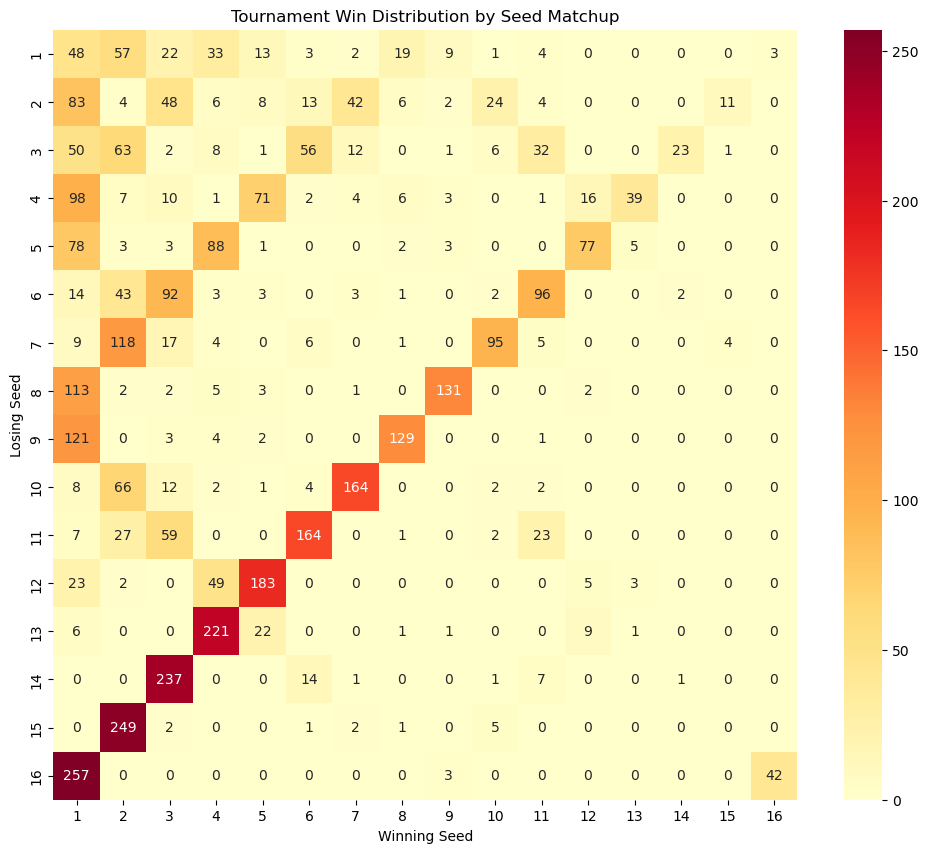

In [13]:
## display a heatmap of win distribution by seed matchup.
# Create a crosstab of winner seed vs loser seed
win_matrix = pd.crosstab(
    index=tourney_compact['LSeedValue'],
    columns=tourney_compact['WSeedValue']
).fillna(0)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(win_matrix, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Tournament Win Distribution by Seed Matchup')
plt.xlabel('Winning Seed')
plt.ylabel('Losing Seed')
plt.show()



In [14]:
seed_performance = tourney_compact.copy()
seed_performance['Upset'] = seed_performance['WSeedValue'] > seed_performance['LSeedValue']

# Group by seed and calculate win percentage
seed_stats = seed_performance.groupby('WSeedValue').agg({
    'Season': 'count',  # Total wins by this seed
    'Upset': 'sum'      # Number of upsets by this seed
}).rename(columns={'Season': 'Wins'})

# Add visualization
fig = px.bar(seed_stats, x=seed_stats.index, y='Wins', 
             title='Tournament Wins by Seed (1985-2024)',
             labels={'WSeedValue': 'Seed', 'Wins': 'Number of Wins'},
             color='Upset', color_continuous_scale='Viridis')
fig.update_layout(xaxis_title='Seed', yaxis_title='Number of Wins')
fig.show()